In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from pyproj import Transformer
import seaborn as sns

In [7]:
# 读取数据
data = pd.read_csv(r"F:\ArcgisData\pred_soildeep\feature_result\feature_deep_2.csv")
print(len(data))
# 删除有缺失值的行
# data.dropna(inplace=True)
# len(data),data.columns
# 填补缺失值为列均值
data.fillna(data.mean(),inplace=True)
len(data),data.columns

5443


(5443,
 Index(['deep', 'Analytical Hillshading.tif', 'Aspect.tif',
        'Channel Network Base Level.tif', 'Channel Network Distance.tif',
        'Closed Depressions.tif', 'Convergence Index.tif', 'DEM2.tif',
        'LAT.tif', 'LON.tif', 'LS-Factor.tif', 'MRRTF.tif', 'MRVBF.tif',
        'NDVI.tif', 'Plan Curvature.tif', 'PRE.tif', 'Profile Curvature.tif',
        'Relative Slope Position.tif', 'Slope.tif', 'TMP.tif',
        'Topographic Wetness Index.tif', 'Total Catchment Area.tif',
        'Valley Depth.tif'],
       dtype='object'))

In [8]:
features_list  = data.columns

In [10]:
features_list = [_.replace('.tif','').replace(' ','').replace('2','') for _ in features_list]

In [11]:
features_list

['deep',
 'AnalyticalHillshading',
 'Aspect',
 'ChannelNetworkBaseLevel',
 'ChannelNetworkDistance',
 'ClosedDepressions',
 'ConvergenceIndex',
 'DEM',
 'LAT',
 'LON',
 'LS-Factor',
 'MRRTF',
 'MRVBF',
 'NDVI',
 'PlanCurvature',
 'PRE',
 'ProfileCurvature',
 'RelativeSlopePosition',
 'Slope',
 'TMP',
 'TopographicWetnessIndex',
 'TotalCatchmentArea',
 'ValleyDepth']

In [12]:
data.columns = features_list

In [14]:
duplicates = data.duplicated(subset=list(data.columns)[1:], keep='first')
df_duplicates = data[duplicates]
df_duplicates

,deep,AnalyticalHillshading,Aspect,ChannelNetworkBaseLevel,ChannelNetworkDistance,ClosedDepressions,ConvergenceIndex,DEM,LAT,LON,...,NDVI,PlanCurvature,PRE,ProfileCurvature,RelativeSlopePosition,Slope,TMP,TopographicWetnessIndex,TotalCatchmentArea,ValleyDepth
390,150.0,0.785462,2.100550,449.14180,0.000977,55.142790,-7.497577,394,3092288.0,587391.7,...,6650.2500,-3.643289e-07,891.4167,-7.648053e-08,0.000003,0.000065,170.50000,13.830962,41686.7340,388.224500
397,150.0,0.785545,3.324775,449.24350,0.000000,31.243500,2.202669,418,3095018.0,588441.7,...,6037.3335,2.088088e-07,897.9167,-1.070836e-07,0.000000,0.000260,169.66667,13.979419,41189.9380,481.736940
400,150.0,0.637644,4.504893,993.74060,263.259400,13.670586,0.586524,1257,3095918.0,584511.7,...,6098.6665,3.071205e-04,951.5833,2.143910e-04,0.825279,0.574416,142.25000,5.396071,5072.3755,55.735107
402,150.0,0.453715,5.237184,1055.25220,266.747800,13.670586,-1.175648,1322,3096308.0,584721.7,...,6098.6665,4.244558e-04,973.8333,2.749915e-03,0.879526,0.350776,134.83333,5.212309,2752.7610,36.537964
801,122.0,0.891198,2.245460,595.09170,8.908325,13.670586,1.014819,604,3041828.0,611751.7,...,4736.6665,1.751857e-04,893.0833,-3.928075e-05,0.038599,0.106391,167.25000,6.214145,2250.5290,221.881840
837,150.0,0.709665,0.124537,441.47202,0.532806,1.004822,-1.086265,441,3038618.0,622581.7,...,5757.2500,-2.318897e-04,902.7500,-2.398353e-03,0.001825,0.133487,168.33333,7.065411,5265.8403,291.478150
974,150.0,0.920590,3.141593,473.00784,138.992160,13.670586,13.357485,612,3072248.0,628341.7,...,6824.5835,1.545274e-03,918.0000,3.737997e-03,0.628751,0.181320,173.25000,5.584193,1464.0193,82.068726
3397,150.0,0.705210,6.118461,961.09060,1.919495,0.010071,8.006558,963,3012368.0,394941.7,...,4744.8335,8.069039e-04,806.5000,-3.089248e-04,0.014013,0.100946,157.91667,6.652492,2708.3020,135.061890


In [15]:
# 去除重复数据
data.drop_duplicates(subset=list(data.columns)[1:], keep='first', inplace=True)

In [16]:
data

,deep,AnalyticalHillshading,Aspect,ChannelNetworkBaseLevel,ChannelNetworkDistance,ClosedDepressions,ConvergenceIndex,DEM,LAT,LON,...,NDVI,PlanCurvature,PRE,ProfileCurvature,RelativeSlopePosition,Slope,TMP,TopographicWetnessIndex,TotalCatchmentArea,ValleyDepth
0,120.0,0.785392,3.973112,596.00745,1.028931,7.036377,5.970561,590,2888588.0,482541.7,...,4910.6665,0.000166,868.6667,-0.000779,0.002889,0.000140,174.25000,10.895318,2.285340e+03,355.07470
1,120.0,0.517938,4.781245,776.89120,139.108830,13.670586,-3.790139,916,2889158.0,503571.7,...,6050.4165,-0.001390,882.4167,0.000392,0.544171,0.451156,167.66667,7.126701,1.929384e+04,116.52576
2,123.0,0.785422,1.570796,626.02340,0.002930,9.026306,-40.219276,617,2889848.0,482091.7,...,5436.8335,-0.000701,868.0833,-0.000092,0.000008,0.000034,174.75000,15.540876,1.684372e+05,345.17444
3,120.0,0.834901,0.983165,566.00000,0.000000,13.670586,-19.254020,566,2890598.0,489051.7,...,6455.5835,-0.002752,870.6667,-0.001942,0.000000,0.178319,172.25000,8.914878,5.579611e+04,330.00060
4,122.0,0.694373,4.854286,833.65160,9.348389,13.670586,-6.661344,843,2894228.0,481791.7,...,5354.0835,-0.000590,875.5000,0.000158,0.057459,0.117310,168.83333,8.055765,1.260766e+04,153.34875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5438,130.0,0.785691,3.926255,1149.72850,0.275879,0.004395,1.170742,1150,2933318.0,398031.7,...,6169.3335,0.000130,830.0833,-0.001083,0.000790,0.023468,150.83333,9.776595,1.754344e+04,349.12292
5439,135.0,0.880185,2.820594,1110.00000,0.000000,13.670586,-1.512934,1110,2932298.0,395211.7,...,6061.9165,-0.000048,826.8333,-0.001153,0.000000,0.104919,152.75000,7.689380,8.728205e+03,339.90760
5440,135.0,0.764459,4.248546,1155.58890,1.411133,13.670586,-1.028052,1157,2933588.0,397911.7,...,6169.3335,0.000086,830.0833,-0.000245,0.004052,0.074369,150.83333,7.757059,7.011773e+03,346.82520
5441,130.0,0.785447,2.356194,1080.02480,0.000000,2.024780,-0.521276,1078,2929028.0,395301.7,...,5336.6665,-0.000059,829.5833,-0.000961,0.000000,0.000049,153.50000,17.570060,1.812242e+06,339.16516


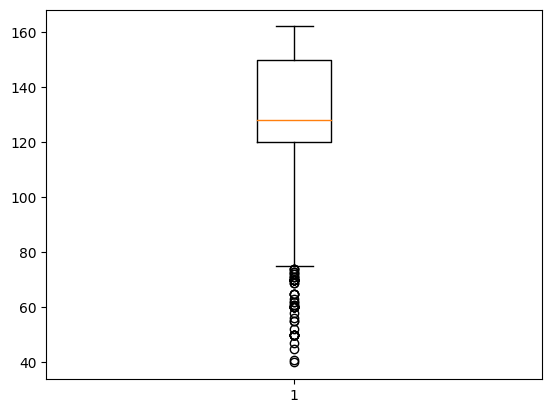

(5435, 23)


In [17]:
plt.boxplot(data["deep"])
plt.show()
print(data.shape)

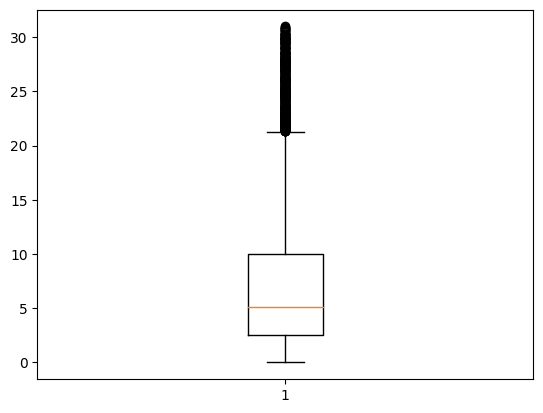

(7750, 23)


In [49]:
# 剔除离群值（Z-score）
z_scores = (data["deep"]-data["deep"].mean())/data["deep"].std()
z_scores.describe()
# 设置阈值
z_score_filter= 1

z_filter_data = data[z_scores<z_score_filter]
z_filter_data
plt.boxplot(z_filter_data["deep"])
plt.show()
print(z_filter_data.shape)

In [18]:
data.columns

Index(['deep', 'AnalyticalHillshading', 'Aspect', 'ChannelNetworkBaseLevel',
       'ChannelNetworkDistance', 'ClosedDepressions', 'ConvergenceIndex',
       'DEM', 'LAT', 'LON', 'LS-Factor', 'MRRTF', 'MRVBF', 'NDVI',
       'PlanCurvature', 'PRE', 'ProfileCurvature', 'RelativeSlopePosition',
       'Slope', 'TMP', 'TopographicWetnessIndex', 'TotalCatchmentArea',
       'ValleyDepth'],
      dtype='object')

In [19]:
features_list = ['deep', 'AnalyticalHillshading', 'Aspect', 'ChannelNetworkBaseLevel',
       'ChannelNetworkDistance', 'ConvergenceIndex',
       'DEM', 'LAT', 'LON', 'LS-Factor', 'MRRTF', 'MRVBF', 'NDVI',
       'PlanCurvature', 'PRE', 'ProfileCurvature', 'RelativeSlopePosition',
       'Slope', 'TMP', 'TopographicWetnessIndex', 'TotalCatchmentArea',
       'ValleyDepth'
       ]

In [20]:
# 筛选指定特征
data = data[features_list]

In [21]:
data

,deep,AnalyticalHillshading,Aspect,ChannelNetworkBaseLevel,ChannelNetworkDistance,ConvergenceIndex,DEM,LAT,LON,LS-Factor,...,NDVI,PlanCurvature,PRE,ProfileCurvature,RelativeSlopePosition,Slope,TMP,TopographicWetnessIndex,TotalCatchmentArea,ValleyDepth
0,120.0,0.785392,3.973112,596.00745,1.028931,5.970561,590,2888588.0,482541.7,0.000451,...,4910.6665,0.000166,868.6667,-0.000779,0.002889,0.000140,174.25000,10.895318,2.285340e+03,355.07470
1,120.0,0.517938,4.781245,776.89120,139.108830,-3.790139,916,2889158.0,503571.7,41.079098,...,6050.4165,-0.001390,882.4167,0.000392,0.544171,0.451156,167.66667,7.126701,1.929384e+04,116.52576
2,123.0,0.785422,1.570796,626.02340,0.002930,-40.219276,617,2889848.0,482091.7,0.000450,...,5436.8335,-0.000701,868.0833,-0.000092,0.000008,0.000034,174.75000,15.540876,1.684372e+05,345.17444
3,120.0,0.834901,0.983165,566.00000,0.000000,-19.254020,566,2890598.0,489051.7,17.567184,...,6455.5835,-0.002752,870.6667,-0.001942,0.000000,0.178319,172.25000,8.914878,5.579611e+04,330.00060
4,122.0,0.694373,4.854286,833.65160,9.348389,-6.661344,843,2894228.0,481791.7,6.122636,...,5354.0835,-0.000590,875.5000,0.000158,0.057459,0.117310,168.83333,8.055765,1.260766e+04,153.34875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5438,130.0,0.785691,3.926255,1149.72850,0.275879,1.170742,1150,2933318.0,398031.7,0.791218,...,6169.3335,0.000130,830.0833,-0.001083,0.000790,0.023468,150.83333,9.776595,1.754344e+04,349.12292
5439,135.0,0.880185,2.820594,1110.00000,0.000000,-1.512934,1110,2932298.0,395211.7,4.374940,...,6061.9165,-0.000048,826.8333,-0.001153,0.000000,0.104919,152.75000,7.689380,8.728205e+03,339.90760
5440,135.0,0.764459,4.248546,1155.58890,1.411133,-1.028052,1157,2933588.0,397911.7,2.505194,...,6169.3335,0.000086,830.0833,-0.000245,0.004052,0.074369,150.83333,7.757059,7.011773e+03,346.82520
5441,130.0,0.785447,2.356194,1080.02480,0.000000,-0.521276,1078,2929028.0,395301.7,0.001654,...,5336.6665,-0.000059,829.5833,-0.000961,0.000000,0.000049,153.50000,17.570060,1.812242e+06,339.16516


In [22]:
# 划分测试数据
train_data,test_data = train_test_split(data,test_size=0.2,random_state=42)
train_data.shape,test_data.shape

((4348, 22), (1087, 22))

In [61]:
# 划分测试数据
train_data,test_data = train_test_split(z_filter_data,test_size=0.2,random_state=0)
train_data.shape,test_data.shape

((6200, 23), (1550, 23))

In [23]:
label = 'deep'
train_data[label].describe()

count    4348.000000
mean      129.795078
std        16.707406
min        40.000000
25%       120.000000
50%       127.500000
75%       150.000000
max       162.000000
Name: deep, dtype: float64

In [24]:
# TabularPredictor.load("AutogluonModels\ag-20230802_083815\")  全要素
# TabularPredictor.load("AutogluonModels\ag-20230803_041226\")  全要素  presets="best_quality"

# predictor = TabularPredictor(label=label).fit(train_data,time_limit=6000,presets="best_quality")
# predictor = TabularPredictor.load(r"AutogluonModels\ag-20230803_041226")

# 模型存放位置
model_path = r"F:\ArcgisData\pred_soildeep\pred_model\test20240418"
# model_path = r'D:\ArcgisData\pred_organic\organic_pred_moudle\对数化'
predictor = TabularPredictor(label=label,path=model_path,eval_metric='r2',problem_type='regression')
# predictor.fit(train_data,time_limit=10800,presets="best_quality",num_stack_levels = 5,num_bag_folds = 5,num_bag_sets = 30)
# predictor.fit(train_data,time_limit=10800,num_stack_levels = 5,num_bag_folds = 5,num_bag_sets = 30)
# predictor = TabularPredictor.load(model_path)
predictor.fit(train_data,time_limit=10800)

No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "F:\ArcgisData\pred_soildeep\pred_model\test20240418"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          20
Memory Avail:       51.16 GB / 63.81 GB (80.2%)
Disk Space Ava

In [25]:
# 获取最佳模型
best_model = predictor.get_model_best()
print(best_model)

# 获取模型的训练摘要
predictor.fit_summary()

C:\Users\Runker\AppData\Local\Temp\ipykernel_21072\3741503116.py:2: DeprecationWarning: `get_model_best` has been deprecated and will be removed in version 1.2. Please use `model_best` instead. This will raise an error in the future!
  best_model = predictor.get_model_best()


WeightedEnsemble_L2
*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.249799          r2       0.067263  13.694183                0.000000           0.201377            2       True         12
1       RandomForestMSE   0.232252          r2       0.032511   1.649011                0.032511           1.649011            1       True          5
2         LightGBMLarge   0.230208          r2       0.000000   0.965281                0.000000           0.965281            1       True         11
3         ExtraTreesMSE   0.228256          r2       0.034752   0.380543                0.034752           0.380543            1       True          7
4               XGBoost   0.223973          r2       0.000000   0.706596                0.000000           0.706596            1       True          9
5           

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesMSE': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': 0.10322298341213021,
  'KNeighborsDist': 0.10451103284809626,
  'LightGBMXT': 0.17964641642253476,
  'LightGBM': 0.21158446928335584,
  'RandomForestMSE': 0.23225228971106082,
  'CatBoost': 0.1926967440771229,
  'ExtraTreesMSE': 0.22825590312215605,
  'NeuralNetFastAI': 0.10982079766972808,
  'XGBoost': 0.22397307921471898,
  'NeuralNetTorch': 0.1290776221530101,
  'LightGBMLarge': 0.23020805518937992,
  'WeightedEnsemble_L2': 0.24979855527906059},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': [

In [19]:
# 测试数据集
y_test_pred = predictor.predict(test_data.drop(columns=[label]))
y_test = test_data[label]
# 训练数据
y_train_pred = predictor.predict(train_data.drop(columns=[label]))
y_train = train_data[label]
# 计算残差
residuals_test =y_train - y_train_pred

In [20]:
predictor.leaderboard(train_data, silent=True)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge,0.890783,0.322022,r2,0.024887,0.007201,1.625934,0.024887,0.007201,1.625934,1,True,11
1,ExtraTreesMSE,0.851960,0.347955,r2,0.168379,0.034167,0.665525,0.168379,0.034167,0.665525,1,True,7
2,RandomForestMSE,0.851141,0.344129,r2,0.153532,0.033365,3.012661,0.153532,0.033365,3.012661,1,True,5
3,WeightedEnsemble_L2,0.764736,0.358678,r2,0.392343,0.085983,24.996165,0.003000,0.000000,0.216723,2,True,12
4,LightGBM,0.692292,0.339745,r2,0.017483,0.002170,0.732281,0.017483,0.002170,0.732281,1,True,4
5,XGBoost,0.610742,0.329764,r2,0.029939,0.012727,1.030438,0.029939,0.012727,1.030438,1,True,9
6,CatBoost,0.562067,0.341685,r2,0.002852,0.000000,14.233155,0.002852,0.000000,14.233155,1,True,6
7,LightGBMXT,0.546528,0.315270,r2,0.009542,0.014485,1.018046,0.009542,0.014485,1.018046,1,True,3
8,NeuralNetFastAI,0.464951,0.275390,r2,0.046359,0.015626,3.716564,0.046359,0.015626,3.716564,1,True,8
9,KNeighborsDist,0.463737,-0.017491,r2,0.010606,0.000000,0.052088,0.010606,0.000000,0.052088,1,True,2


In [21]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.225900,0.306134,r2,0.176851,0.067947,7.799404,0.000000,0.000000,0.199936,2,True,12
1,CatBoost,0.201021,0.253999,r2,0.000000,0.000000,2.266841,0.000000,0.000000,2.266841,1,True,6
2,LightGBMLarge,0.192232,0.269456,r2,0.001872,0.012294,1.168425,0.001872,0.012294,1.168425,1,True,11
3,RandomForestMSE,0.190836,0.270646,r2,0.158425,0.033604,2.694662,0.158425,0.033604,2.694662,1,True,5
4,LightGBM,0.181697,0.258229,r2,0.009907,0.000000,0.454120,0.009907,0.000000,0.454120,1,True,4
5,XGBoost,0.173765,0.261415,r2,0.015044,0.016598,1.066913,0.015044,0.016598,1.066913,1,True,9
6,ExtraTreesMSE,0.158926,0.236664,r2,0.165247,0.032365,0.666368,0.165247,0.032365,0.666368,1,True,7
7,LightGBMXT,0.145483,0.232367,r2,0.010786,0.000000,1.716756,0.010786,0.000000,1.716756,1,True,3
8,KNeighborsUnif,0.105237,0.187084,r2,0.001510,0.005451,2.653359,0.001510,0.005451,2.653359,1,True,1
9,NeuralNetTorch,0.070889,0.119694,r2,0.016556,0.001661,5.282219,0.016556,0.001661,5.282219,1,True,10


In [22]:

# 训练集指标
train_metrics = predictor.leaderboard(train_data, silent=True) 

# 测试集指标
test_metrics = predictor.leaderboard(test_data, silent=True)

# 获取指标名称
metric_name = list(train_metrics.keys())[0]  


In [23]:
pd_train = train_metrics[['model','score_test']]
pd_test = test_metrics[['model','score_test']]
pd_result = pd.merge(pd_train,pd_test,on='model')

In [24]:
pd_result
pd_result.rename(columns = {"model":"Model","score_test_x":"Train Set","score_test_y":"Test  Set"},inplace=True)

In [25]:
pd_result

,Model,Train Set,Test Set
0,RandomForestMSE,0.832054,0.190836
1,ExtraTreesMSE,0.825842,0.158926
2,XGBoost,0.763924,0.173765
3,LightGBMLarge,0.741805,0.192232
4,WeightedEnsemble_L2,0.718664,0.225900
5,LightGBMXT,0.550492,0.145483
6,CatBoost,0.501026,0.201021
7,LightGBM,0.432692,0.181697
8,KNeighborsDist,0.417979,0.013967
9,KNeighborsUnif,0.347334,0.105237


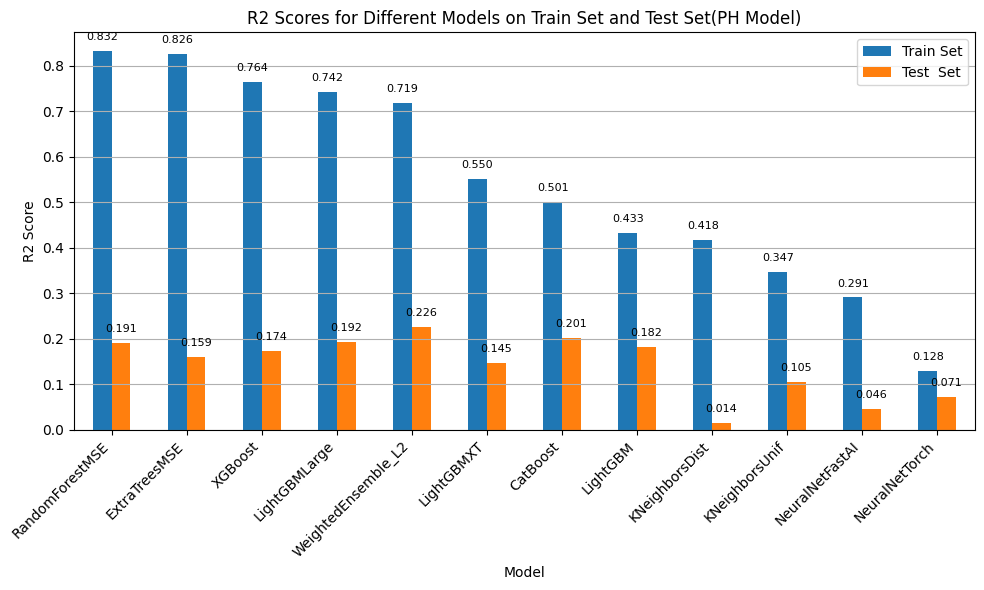

In [26]:
ax = pd_result.set_index('Model').plot(kind='bar', figsize=(10,6))
plt.title('R2 Scores for Different Models on Train Set and Test Set(PH Model)')
plt.ylabel('R2 Score')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')

# 添加数值标签
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points',fontsize=8, 
                )

plt.tight_layout()
plt.show()


In [27]:
# 克里金残差训练
OK = OrdinaryKriging(train_data['LON'], train_data['LAT'], residuals_test, variogram_model='spherical')  #variogram_model:linear,gaussian,exponential,spherical
kriging_predictions_test, _ = OK.execute('points', test_data['LON'], test_data['LAT'])
predictions_test = y_test_pred + kriging_predictions_test
# 计算R2
r2 = r2_score(y_test, predictions_test)
r2

0.2593780959266241

In [28]:
test_data.describe()

,pH,AnalyticalHillshading,Aspect,ChannelNetworkBaseLevel,ChannelNetworkDistance,ClosedDepressions,ConvergenceIndex,dem,LSFactor,PlanCurvature,...,Entropy,Homogeneity,Mean,ndvi,PCA_0,PCA_1,SecondMoment,Variance,LON,LAT
count,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,...,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,7.360000e+02
mean,6.312038,0.758434,3.642877,1053.484781,18.478324,1.050462,-0.045805,1071.841576,11.966394,0.001438,...,0.987701,0.784620,8.655495,0.331078,0.058373,0.044469,0.459642,0.278214,404713.858696,2.995501e+06
std,1.090224,0.256257,1.805062,169.519482,20.503093,1.019276,6.980420,167.008876,12.813596,0.008030,...,0.502304,0.133149,1.190473,0.084226,0.082403,0.056891,0.238286,0.378524,11423.463959,1.624038e+04
min,4.290000,0.109064,0.000940,594.767000,0.000000,0.002991,-73.055565,604.900000,0.000446,-0.047492,...,-0.000000,0.239869,3.444445,0.048033,-0.305437,-0.118440,0.111111,0.000000,375715.000000,2.964105e+06
25%,5.390000,0.590880,2.070567,949.023008,2.953400,1.066605,-1.209896,966.875000,3.369095,-0.001646,...,0.636514,0.688889,8.000000,0.269700,0.004246,0.007154,0.283951,0.098765,395878.750000,2.981671e+06
50%,6.180000,0.773469,4.047021,1049.549250,12.841919,1.066605,0.474166,1069.500000,9.064063,0.000795,...,1.060857,0.777778,8.666666,0.330208,0.056473,0.044826,0.382716,0.222222,405092.500000,2.994832e+06
75%,7.220000,0.901969,5.130608,1164.048275,26.880401,1.066605,2.083011,1181.350000,16.929041,0.004448,...,1.310784,0.888889,9.333334,0.392745,0.104222,0.084065,0.555556,0.246914,413971.250000,3.008158e+06
max,9.320000,1.927235,6.283186,1455.627100,143.149720,20.471680,29.430452,1462.200000,121.984340,0.043012,...,2.197225,1.000000,12.777779,0.530876,0.316659,0.314779,1.000000,3.777777,428495.000000,3.028625e+06


In [29]:
# 重新计算预测值

def calc_predict_value(actual_value, predict_value):
    diff = np.abs(actual_value - predict_value)/actual_value
    modified_diff = np.where(diff <= 0.15, actual_value, predict_value)
    return modified_diff


In [30]:
t_pred = calc_predict_value(test_data[label],y_test_pred)
t_pred

array([6.85006762, 6.68505907, 7.61      , 6.74      , 6.24486828,
       6.4       , 6.06      , 6.32      , 6.22900343, 6.73464966,
       5.39      , 5.36      , 8.33      , 7.78      , 6.20892668,
       6.77      , 6.94      , 6.10202551, 6.81      , 5.44      ,
       7.42      , 5.65      , 6.19344521, 6.55409241, 5.04      ,
       8.04      , 6.90528011, 5.29      , 6.46      , 6.56      ,
       6.12590599, 5.94      , 5.22      , 6.02      , 5.78      ,
       6.29      , 5.92808294, 6.06      , 6.82276392, 6.09548759,
       5.943995  , 5.98      , 5.76      , 5.37      , 6.59458733,
       6.21      , 5.06      , 6.84      , 6.89430237, 5.87      ,
       6.34      , 6.37197065, 5.487257  , 6.76783895, 6.36      ,
       6.05753469, 5.96086407, 7.68      , 5.98077679, 6.58      ,
       6.        , 5.76      , 5.73      , 6.01159954, 7.04      ,
       6.19036293, 5.2       , 5.78842545, 6.76      , 6.24      ,
       6.44820452, 6.23400974, 6.37834644, 6.00346422, 7.19   

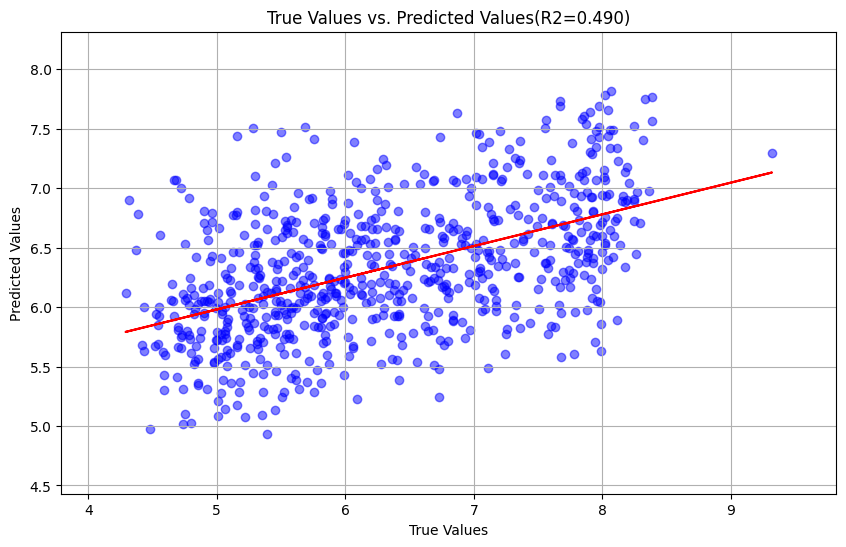

In [31]:
# plt.scatter(y_test, predictions_test)

# # 添加标签和标题
# plt.xlabel('True Values')
# plt.ylabel('Predicted Values')
# plt.title('True Values vs. Predicted Values')

# # 显示图表
# plt.show()
# 画图
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions_test, c='b', alpha=0.5)

fit = np.polyfit(y_test, predictions_test, deg=1)
fit_fn = np.poly1d(fit) 
plt.plot(y_test, fit_fn(y_test), c='r')

plt.xlim([min(y_test)-0.5, max(y_test)+0.5])
plt.ylim([min(predictions_test)-0.5, max(predictions_test)+0.5])
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs. Predicted Values(R2=0.490)')
plt.grid()

plt.show()

In [ ]:
# 创建折线图
plt.figure(figsize=(52,10))
plt.plot(y_test, label='True Values')
plt.plot(predictions_test, label='Predicted Values')

# 图表标题和标签
plt.title('True Values vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [33]:
predictor.evaluate(test_data, silent=True)

{'r2': 0.225900159458981,
 'root_mean_squared_error': -0.958558920999621,
 'mean_squared_error': -0.9188352050279577,
 'mean_absolute_error': -0.8071567782370941,
 'pearsonr': 0.47625773567739504,
 'median_absolute_error': -0.7393293952941895}

In [34]:
perf = predictor.evaluate_predictions(y_train,y_train_pred,auxiliary_metrics=True,detailed_report=True)

In [35]:
perf = predictor.evaluate_predictions(y_test,y_test_pred,auxiliary_metrics=True,detailed_report=True)

In [36]:

def calculate_modified_r2(y_true, y_pred):
    diff = np.abs(y_true - y_pred)/y_true
    modified_diff = np.where(diff <= 0.2, 0, np.abs(y_true - y_pred))
    modified_ssr = np.sum(modified_diff**2)
    
    mean = np.mean(y_true)
    total_diff = np.sum((y_true - mean)**2)
    
    r2 = 1 - (modified_ssr / total_diff)
    return r2

print(calculate_modified_r2(test_data[label], y_test_pred))

0.5841839906796586


In [37]:
metrics = predictor.evaluate(test_data, silent=True)

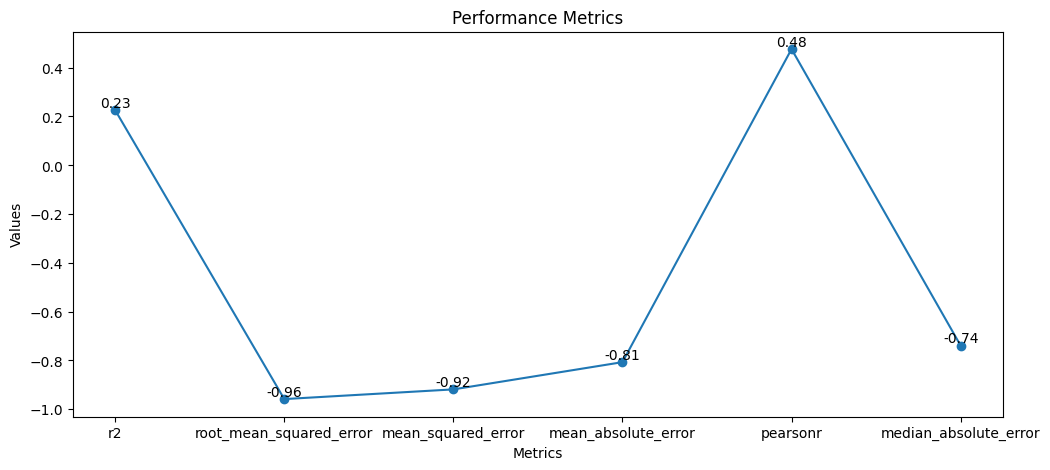

In [38]:
metric_names = list(metrics.keys())
metric_values = list(metrics.values())
plt.figure(figsize=(12,5))
plt.plot(metric_names, metric_values, marker='o')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics')

# 标注数值
for i in range(len(metric_names)):
    plt.annotate(f'{metric_values[i]:.2f}', (metric_names[i], metric_values[i]), ha='center', va='bottom')

plt.show()


In [39]:
fetures_value = predictor.feature_importance(train_data)
# 将索引添加为列

Computing feature importance via permutation shuffling for 34 features using 5000 rows with 5 shuffle sets...
	39.31s	= Expected runtime (7.86s per shuffle set)
	8.11s	= Actual runtime (Completed 5 of 5 shuffle sets)


In [40]:
df = fetures_value
df.reset_index(level=0, inplace=True)

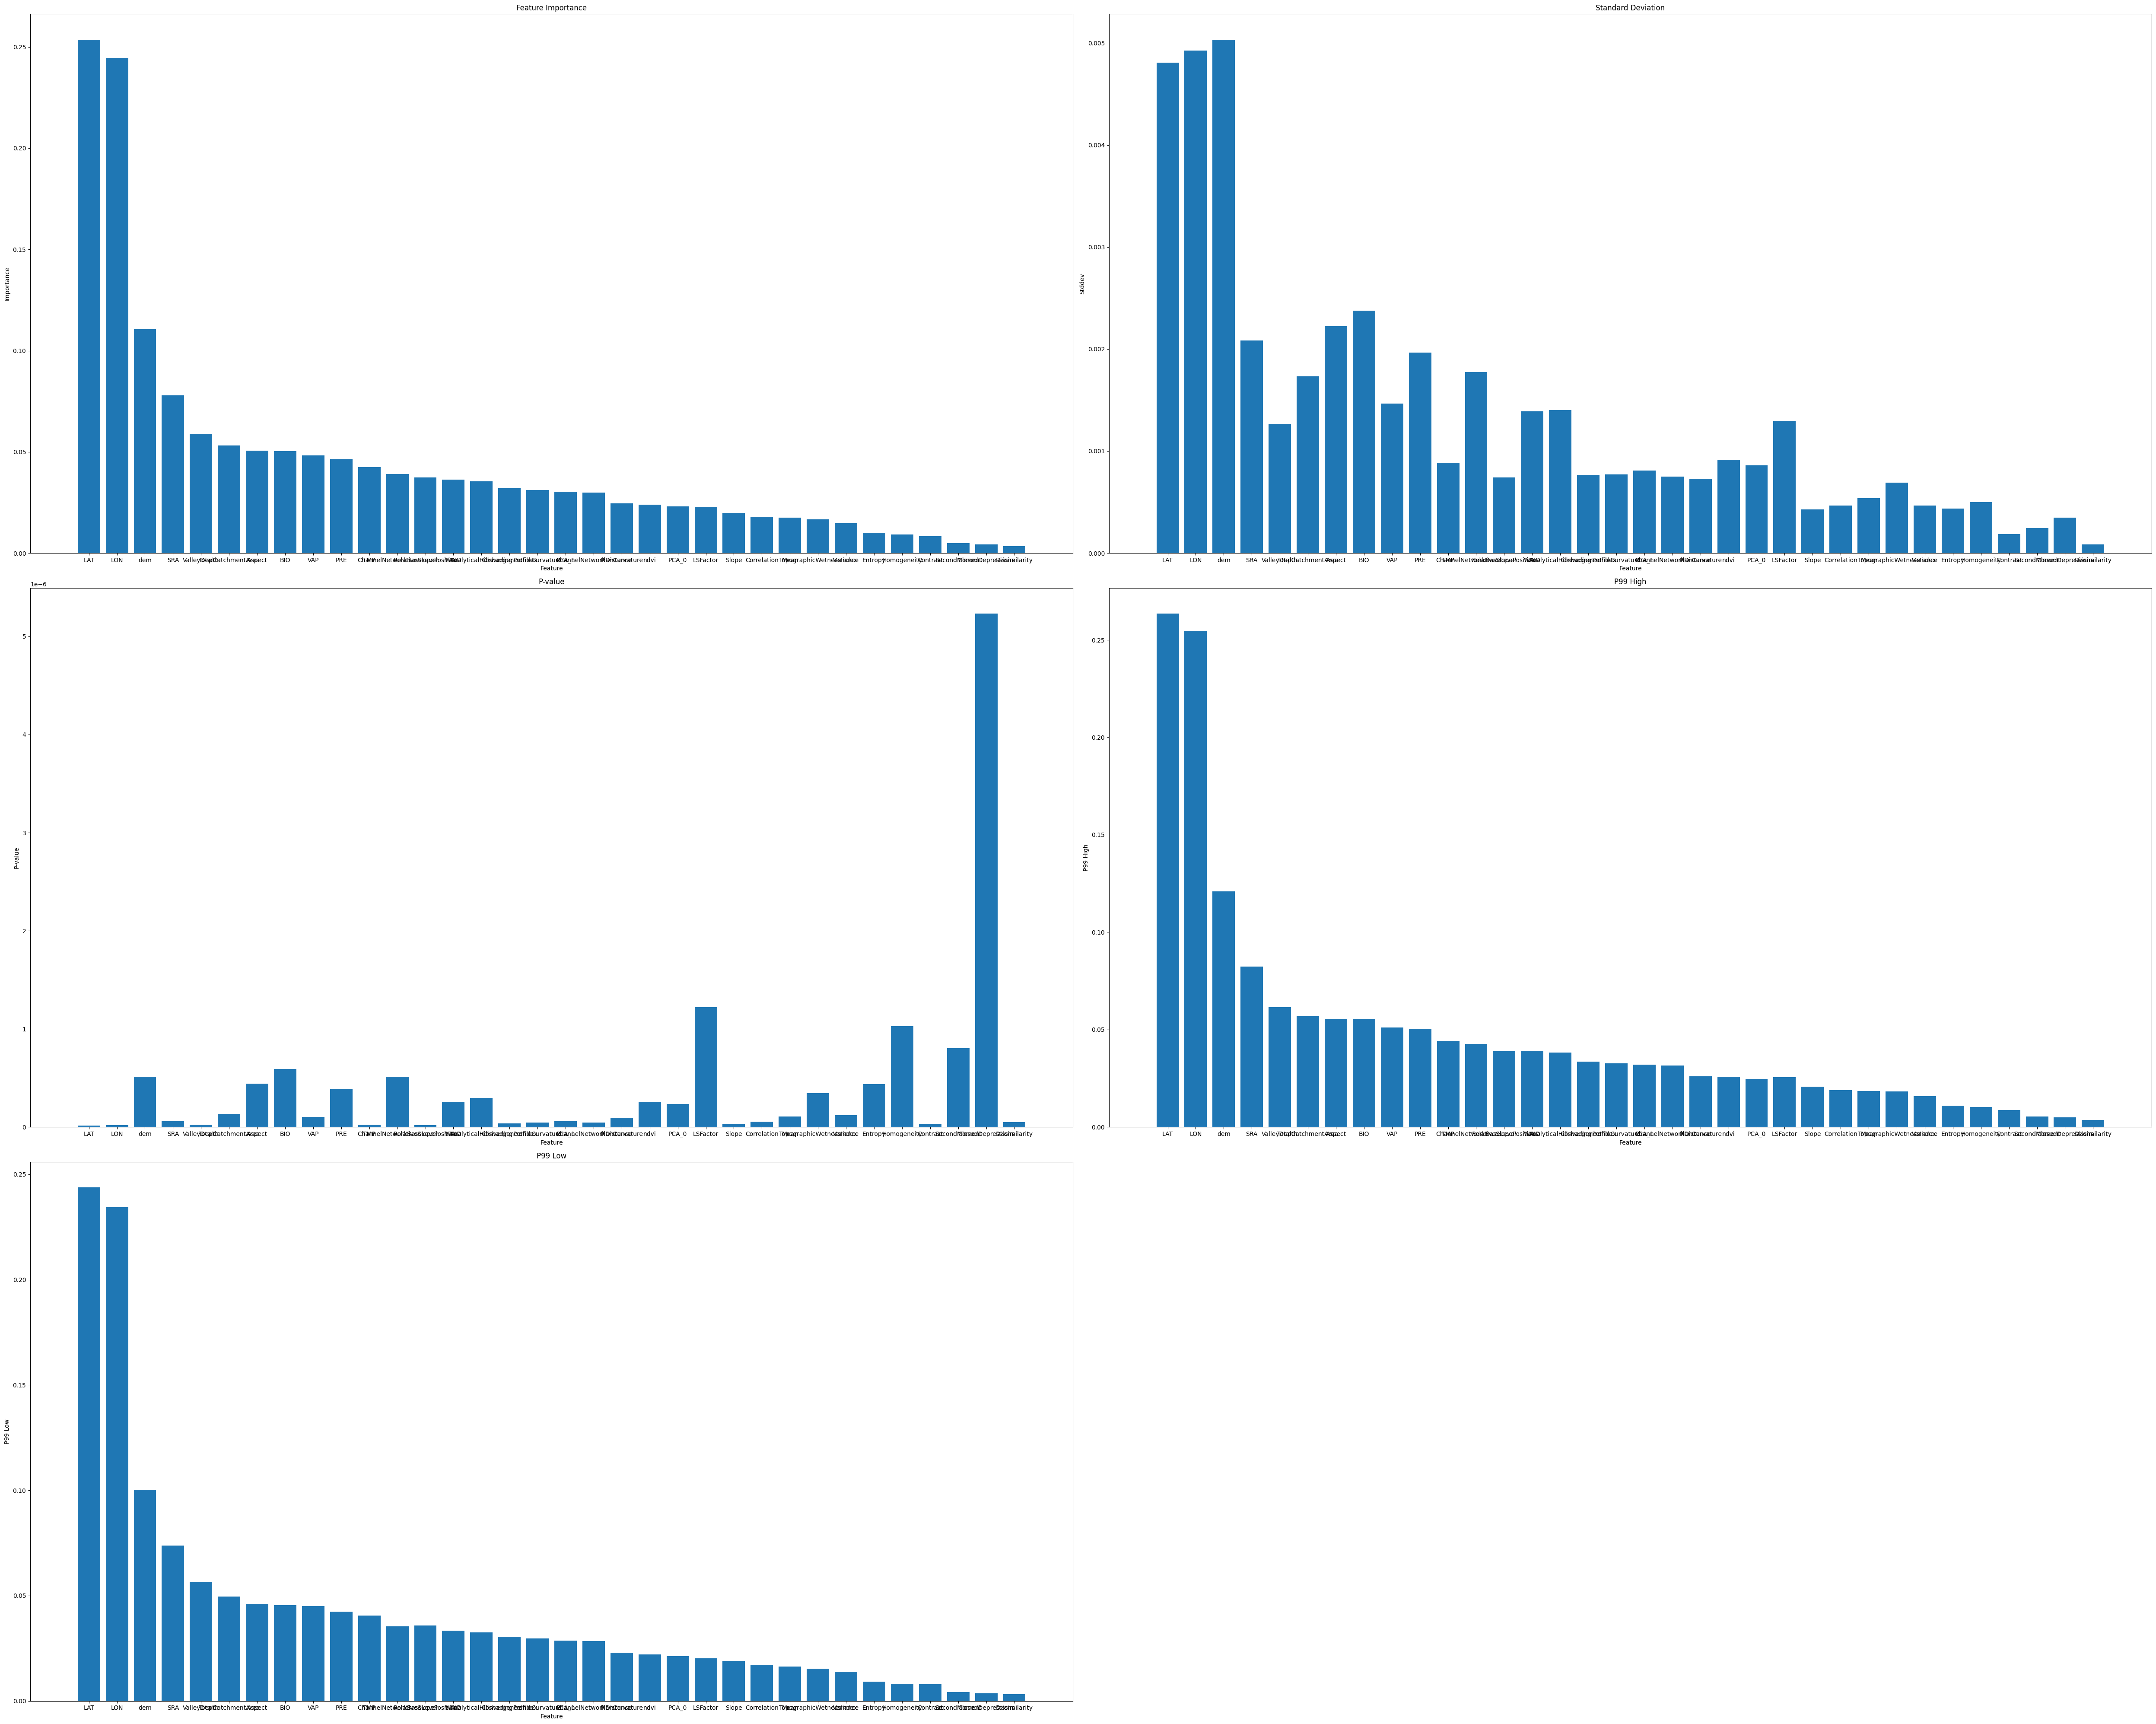

In [41]:
import matplotlib.pyplot as plt

# 设置图表大小
plt.figure(figsize=(50, 40))

# 绘制各个特征的重要性
plt.subplot(3, 2, 1)
plt.bar(df['index'], df['importance'])
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')

# 绘制各个特征的标准差
plt.subplot(3, 2, 2)
plt.bar(df['index'], df['stddev'])
plt.title('Standard Deviation')
plt.xlabel('Feature')
plt.ylabel('Stddev')

# 绘制各个特征的p值
plt.subplot(3, 2, 3)
plt.bar(df['index'], df['p_value'])
plt.title('P-value')
plt.xlabel('Feature')
plt.ylabel('P-value')

# 绘制各个特征的p99高值
plt.subplot(3, 2, 4)
plt.bar(df['index'], df['p99_high'])
plt.title('P99 High')
plt.xlabel('Feature')
plt.ylabel('P99 High')

# 绘制各个特征的p99低值
plt.subplot(3, 2, 5)
plt.bar(df['index'], df['p99_low'])
plt.title('P99 Low')
plt.xlabel('Feature')
plt.ylabel('P99 Low')

# 调整子图之间的间距
plt.tight_layout()

# 展示图表
plt.show()

In [ ]:
"""importance（重要性）：

取值范围：通常是一个非负实数，可以是介于0到无穷大之间的任意值。
意义：表示该特征对目标变量的预测能力的贡献程度。重要性值越高，说明该特征在预测模型中的影响力越大。
stddev（标准差）：

取值范围：通常是一个非负实数，可以是大于等于0的任意值。
意义：衡量特征值分散程度的统计指标。标准差值越大，表示样本数据在该特征上的波动越大。
p_value（P值）：

取值范围：通常是一个小于等于1的实数，可能是非负实数或者在特定情况下限制在0到1之间的实数。
意义：用于判断某个变量对目标变量是否具有显著影响。较小的p-value表示该特征与目标变量之间的关系更显著。
n（样本数量）：

取值范围：通常是一个正整数，表示用于计算这些特征参数的样本数量。
意义：表示用于计算特征参数的数据样本的数量。
p99_high（99%置信度上限）和p99_low（99%置信度下限）：

取值范围：通常是实数，可以是任意实数或在特定情况下限制在一定范围内的实数。
意义：表示特征的置信区间。在统计意义下，特征取值不会超过上限或低于下限的概率为99%。"""

In [386]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score

In [43]:

from sklearn.preprocessing import StandardScaler
# 1. 划分数据为特征（X）和目标（y）
X = data.drop(columns=['pH'])
y = data['pH']

# 2. 划分数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((5884, 34), (1471, 34))

In [44]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score

# 建立神经网络模型
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 训练模型
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)

# 使用模型进行预测
y_pred_nn = model.predict(X_test_scaled)

# 计算 R^2 分数
r2_nn = r2_score(y_test, y_pred_nn)

r2_nn


46/46 [==============================] - 0s 369us/step


0.11726000145594673